In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as ss
import os
import itertools
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
from random import sample
from random import normalvariate
from cdlib import algorithms

# Minimum size for the final Leiden communities
MIN_COM_SIZE = 8

# Nice for easily estimating how long things will take to run
from datetime import datetime
from datetime import date

# Graph class from Omics-Integrator. See repo here: https://github.com/fraenkel-lab/OmicsIntegrator2
import graph

# Tools for completing the PCSF analsysis 
import pcsftools as pt 

# Path for the input data
data_path = os.path.dirname(os.getcwd()) + "/data"

# Path for references
ref_path = os.path.dirname(os.getcwd()) + "/ref/"

# Path to for a map between STRING ID and gene names
map_path = ref_path + "human.name_2_string.txt"

# Grab the prepped protein protein interaction network (PPI)
ppi  = pd.read_csv(ref_path + "prepped_STRING_9606.protein.links.v11.5.txt", sep = "\t")
ppi = ppi[['protein1', 'protein2', 'cost']]

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


#### We're now ready to run the Prize Collecting Steiner Forest algo using the provided PPI and the prizes from our data. The problem is defined as follows: 

$$
\text{Find } T(n,e) \Rightarrow \text{ }\psi(T) = \text{min}\bigg[b \sum_{n \notin N_T} p(n) + \sum_{e \in E_T} c^*(e)\bigg]
$$

with $c^*(e)$ defined as:

$$ c^*(e) = \begin{cases} 
      c(e) + \frac{d_x d_y}{d_x d_y  + (N - d_x  - 1) (N - d_y - 1)} 10^g & \text{if } e \in E \\
      w & \text{if } e \in \{\{r,s\} : s \in S\}
   \end{cases}
$$

This requires a few parameters that will determine to the cost of each possible subnetwork is computed: 

- Parameter w: penalizes the inclusion of edges linking terminals to dummy node. High w implies more Steiner nodes in the final network

- Parameter b: penalize the exclusion of prize holding terminal nodes. Higher b implies more prize holding terminal nodes in the final network

- Parameter g: Penalize the inclusion of hub genes with excessive connectivy. For exploratory analsysis in search of the overal network strucutre, no need to include this, set to 0. 

Clearly, we want ensure the solutions that we find are robust, and thus not particularly sensitive to changes in the parameters. To check this, we'll run PCSF for many discrete combinations of b and w that span a reasonable range. We can then compute the Jaccard similarity of the resulting subgraphs and confirm that small changes in these parameters don't redacially alter the solution produced. First, let's get the seeds, or terminals, we want to include in the PCSF solution.

In [2]:
# Cutoff values to include DEGs as seeds
p_cut_DEG = 1e-6
log2_cut = 1

# Cutoff values to include TFs as seeds
p_cut_TF = 0.05
score_cut = 3

### Prep for PCSF in pEF and rEF by selecting only DEGs and TFs that meet the above criteria

In [3]:
# Read in both the DEGs and TFs
DE_df = pd.read_csv(data_path + '/cov_adj_DEGs_deseq.csv', sep = ',')
TF_df = pd.read_csv(data_path + '/z_score_TF_enrichment.csv', sep = ',')

# Convert to string ID
DE_df['string_id'] = pt.convert_to_string_id(DE_df['external_gene_name'], map_path)
TF_df['string_id'] = pt.convert_to_string_id(TF_df['external_gene_name'], map_path)

# Filter DEGs to differntially expressed, large l2FC for HFpEF and HFrEF
pEF_DEGs = DE_df[DE_df['padj_PEF'] < p_cut_DEG]
rEF_DEGs = DE_df[DE_df['padj_REF'] < p_cut_DEG]
pEF_DEGs = pEF_DEGs[np.abs(pEF_DEGs['log2FoldChange_PEF']) > log2_cut]
rEF_DEGs = rEF_DEGs[np.abs(rEF_DEGs['log2FoldChange_REF']) > log2_cut]

# Do the same for TFs
pEF_TFs = TF_df[TF_df['p_adj_PEF'] < p_cut_TF]
rEF_TFs = TF_df[TF_df['p_adj_REF'] < p_cut_TF]
pEF_TFs = pEF_TFs[np.abs(pEF_TFs['score_PEF']) > score_cut]
rEF_TFs = rEF_TFs[np.abs(rEF_TFs['score_REF']) > score_cut]

# Take only those with STRING ids
pEF_DEGs = pEF_DEGs[pEF_DEGs['string_id'].str.contains("9606.")]
rEF_DEGs = rEF_DEGs[rEF_DEGs['string_id'].str.contains("9606.")]
pEF_TFs = pEF_TFs[pEF_TFs['string_id'].str.contains("9606.")]
rEF_TFs = rEF_TFs[rEF_TFs['string_id'].str.contains("9606.")]

# Rescale the TF seed scores to match the DEGs
tf_scale_factor_pEF = np.abs(max(DE_df.z_score_PEF)) / np.abs(max(TF_df.z_score_PEF))
tf_scale_factor_rEF = np.abs(max(DE_df.z_score_REF)) / np.abs(max(TF_df.z_score_REF))

# Take only DEGs for which we don't have a TF value 
pEF_DEGs = pEF_DEGs[~(pEF_DEGs.external_gene_name.isin(pEF_TFs.external_gene_name))]
rEF_DEGs = rEF_DEGs[~(rEF_DEGs.external_gene_name.isin(rEF_TFs.external_gene_name))]


### Build seeds dataframe for PCSF


In [4]:
pEF_seeds = pd.DataFrame({'name':pd.concat([pEF_DEGs.string_id, pEF_TFs.string_id]),
                          'prize' : pd.concat([np.abs(pEF_DEGs.z_score_PEF), (np.abs(pEF_TFs.z_score_PEF) * tf_scale_factor_pEF)]), 
                              'score' : pd.concat([pEF_DEGs.z_score_PEF, (pEF_TFs.z_score_PEF * tf_scale_factor_pEF)]),
                              'gene' : pd.concat([pEF_DEGs.external_gene_name, pEF_TFs.external_gene_name])}).sort_values(by = 'prize', ascending = False)


rEF_seeds = pd.DataFrame({'name':pd.concat([rEF_DEGs.string_id, rEF_TFs.string_id]),
                          'prize' : pd.concat([np.abs(rEF_DEGs.z_score_REF), (np.abs(rEF_TFs.z_score_REF) * tf_scale_factor_rEF)]), 
                              'score' : pd.concat([rEF_DEGs.z_score_REF, (rEF_TFs.z_score_REF * tf_scale_factor_rEF)]),
                              'gene' : pd.concat([rEF_DEGs.external_gene_name, rEF_TFs.external_gene_name])}).sort_values(by = 'prize', ascending = False)

#### Save the seeds with today's date

In [5]:
pEF_seeds.to_csv(data_path + "pEF_seeds_" + str(date.today()) + ".csv", index = False)
rEF_seeds.to_csv(data_path + "rEF_seeds_" + str(date.today()) + ".csv", index = False)

#### Prior to sensitivity analsyis, we need to do some basic math to determine what parameter ranges are acceptable. 

In the case of b, we want the cost of exlcuding a seed node to at least exceed the maximum edge cost. Otherwise, the algo has insentive to exclude thingds we've measured (seeds) in favor of things that haven't been measured (Steiner nodes).

Recall, the edge cost is defined as:

$$ c^*(e) = \begin{cases} 
      c(e) + \frac{d_x d_y}{d_x d_y  + (N - d_x  - 1) (N - d_y - 1)} 10^g & \text{if } e \in E \\
      w & \text{if } e \in \{\{r,s\} : s \in S\}
   \end{cases} $$

This suggests we require $b \geq 1$ to ensure a large number of seeds are retained in the solution.

To determine a range for $w$ to use in thge SA, notice that selecting $w$ too low will result in a trivial solution with all seed nodes connected solely to the root dummy node, and thus isolated in the final solution. Conversely, $w$ set too high will prevent the inclusion of any connections to the root node, and produce a fully-connected solution. SA should thus be conducted using a range of $w$ that spans the distribution of costs for shortest paths between all seed nodes.  

To do this, apply Dijkstra's alorithm to all combinations of seed genes with edges costs given by the PCSF algorithm.  

In [6]:
import importlib
importlib.reload(pt)

<module 'pcsftools' from 'C:\\Users\\Aaron Troy\\Documents\\Bioinformatics\\Network Analysis of HFpEF\\Hahn_FGN_Analysis\\PCSF_Python\\pcsftools.py'>

In [7]:
pEF_path_costs = pt.get_path_costs(pEF_seeds.name, ppi, print_prog = False, sampled_proportion = 0.05)
rEF_path_costs = pt.get_path_costs(rEF_seeds.name, ppi, print_prog = False, sampled_proportion = 0.05)

383250
234270


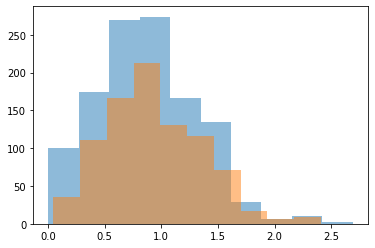

In [19]:
plt.hist(pEF_path_costs.values(), alpha = 0.5)
plt.hist(rEF_path_costs.values(), alpha = 0.5)
plt.show()

#### Set up bounds and sampling density for the sampled parameter space

In [9]:
#Parameter g: Penalize the inclusion of hub genes with excessive connectivy. For exploratory analsysis in search of the overal network strucutre, no need to include this, set to 0. 
g = 0

#Parameter w: penalizes the inclusion of edges linking terminals to dummy node. High w implies more Steiner nodes in the final network
set_w = [round(w, 2) for w in np.linspace(0.2,4,10)]

#Parameter b: penalize the exclusion of prize holding terminal nodes. Higher b implies more prize holding terminal nodes in the final network
set_b = np.linspace(1, 20, 10)

paramCombs = list(itertools.product(set_w, set_b))

In [20]:
pEF_seeds

,name,prize,score,gene
2094,9606.ENSP00000385616,24.301530,-24.301530,SUN2
2305,9606.ENSP00000217159,20.416011,-20.416011,SLCO4A1
7534,9606.ENSP00000270879,20.160681,-20.160681,FCN3
12504,9606.ENSP00000352071,19.079125,-19.079125,CD163
9021,9606.ENSP00000367766,18.621181,-18.621181,RPGR
...,...,...,...,...
15635,9606.ENSP00000401089,5.286329,5.286329,ANKRD34C
7393,9606.ENSP00000269289,5.274729,5.274729,ZMYND15
11233,9606.ENSP00000306884,5.267086,5.267086,CXCL11
7219,9606.ENSP00000475084,5.254933,5.254933,DUOX2


#### Generate th PCSF solutions using different combinations, no noise

This may take awhile, depending on size of the parameter space

In [10]:
sensiResults_pEF = {}
sensiResults_rEF = {}

n = 0

for (w, b) in paramCombs:
    
    print("Progress:", (n * 100) / len(paramCombs), "%")
    
    n = n+1
    
    params = {"w": w, "b": b, "g": 0, "edge_noise": 0, "dummy_mode": "terminals", "seed": 0, "skip_checks": False}
    
    # HFpEF
    
    sensiResults_pEF[(g,w,b)] = pt.run_pcsf(pEF_seeds, ppi, params, addAttribs = False)

    # HFrEF
    
    sensiResults_rEF[(g,w,b)] = pt.run_pcsf(rEF_seeds, ppi, params, time = True, addAttribs = False)
    

Progress: 0.0 %
Current Time = 13:08:23
Progress: 1.0 %
Current Time = 13:08:30
Progress: 2.0 %
Current Time = 13:08:37
Progress: 3.0 %
Current Time = 13:08:43
Progress: 4.0 %
Current Time = 13:08:50
Progress: 5.0 %
Current Time = 13:08:57
Progress: 6.0 %
Current Time = 13:09:03
Progress: 7.0 %
Current Time = 13:09:10
Progress: 8.0 %
Current Time = 13:09:17
Progress: 9.0 %
Current Time = 13:09:23
Progress: 10.0 %
Current Time = 13:09:31
Progress: 11.0 %
Current Time = 13:09:41
Progress: 12.0 %
Current Time = 13:09:51
Progress: 13.0 %
Current Time = 13:10:00
Progress: 14.0 %
Current Time = 13:10:10
Progress: 15.0 %
Current Time = 13:10:20
Progress: 16.0 %
Current Time = 13:10:29
Progress: 17.0 %
Current Time = 13:10:39
Progress: 18.0 %
Current Time = 13:10:49
Progress: 19.0 %
Current Time = 13:10:58
Progress: 20.0 %
Current Time = 13:11:08
Progress: 21.0 %
Current Time = 13:11:18
Progress: 22.0 %
Current Time = 13:11:28
Progress: 23.0 %
Current Time = 13:11:38
Progress: 24.0 %
Current T

#### View a sensitivity heat map 

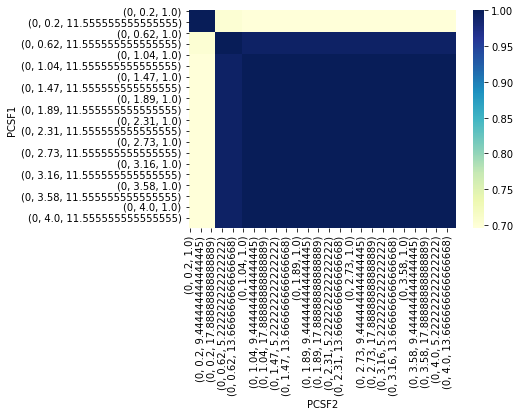

In [14]:
pEF_sensi_mat = pt.make_solution_similarity_matrix(sensiResults_pEF)

sns.heatmap(pEF_sensi_mat, cmap = "YlGnBu")
plt.show()

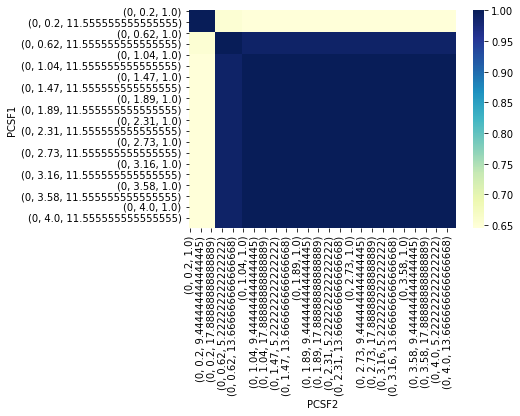

In [15]:
rEF_sensi_mat = pt.make_solution_similarity_matrix(sensiResults_rEF)

sns.heatmap(rEF_sensi_mat, cmap = "YlGnBu")
plt.show()

#### Assemble consensus networks
Having selected a region of staibillity, let's inject some edge noise that will make the solution stochastic.
We can then prune the final solution to only edges that appears in the majoirty of solutions (e.g. 95% or better). 


In [17]:
#Define the number of random solutions to generate
reps = 100

params = {"w": 2, 
          "b": 10, 
          "g": 0, 
          "edge_noise": 0.1,
          "dummy_mode": "terminals",
          "seed": 0,
          "skip_checks": False}

#First, HFpEF
pcsfGraph_pEF = graph.Graph(ppi, params)
pcsfGraph_pEF.prepare_prizes(pEF_seeds)
randomForest_pEF, _ = pcsfGraph_pEF.randomizations(noisy_edges_reps=reps, random_terminals_reps=0)

#Next, HFrEF
pcsfGraph_rEF = graph.Graph(ppi, params)
pcsfGraph_rEF.prepare_prizes(rEF_seeds)
randomForest_rEF, _ = pcsfGraph_rEF.randomizations(noisy_edges_reps=reps, random_terminals_reps=0)

In [21]:
#Define a confidence threshold for nodes to be retained
confThresh = 0.9

#Remove nodes that don't meet the required confidence
consensusForest_pEF = randomForest_pEF.copy()
consensusForest_pEF.remove_nodes_from(
    [node for node, freq in nx.get_node_attributes(consensusForest_pEF, 'robustness').items() if freq < confThresh]
)

#Remove nodes that don't meet the required confidence
consensusForest_rEF = randomForest_rEF.copy()
consensusForest_rEF.remove_nodes_from(
    [node for node, freq in nx.get_node_attributes(consensusForest_rEF, 'robustness').items() if freq < confThresh]
)

#### Apply the Leiden algorithm to identify communities, using the eges costs as weights 

In [22]:
pEF_coms = algorithms.leiden(consensusForest_pEF, weights = 'confidence')
pEF_com_list = pEF_coms.communities

rEF_coms = algorithms.leiden(consensusForest_rEF, weights = 'confidence')
rEF_com_list = rEF_coms.communities

#### Discard communities below some threshold size

In [23]:
while len(pEF_com_list[-1]) < MIN_COM_SIZE:
    pEF_com_list.pop()
    
while len(rEF_com_list[-1]) < MIN_COM_SIZE:
    rEF_com_list.pop()

#### We can annotate known drug targets in the resulting communities using a list of approved FDA targets

Retrieve the list

In [24]:
fda_targets = pd.read_csv(ref_path + '//protein_class_FDA.tsv', sep = '\t')

#### Setup a routine for plotting the Leiden communities

In [25]:
def plot_leiden_com(com, graph, seeds, mapPath, drug_targets = None):

    #Community subgraph
    com_graph = graph.subgraph(com)

    # As a dataframe with gene names
    com_details = pt.get_network_details(com_graph)
    com_details['gene'] = pt.convert_to_gene_symbol(com_details.index, map_path)
    com_details['score'] = 0

    # Get scores for seed nodes in the community
    com_seeds = list(set(com_details.index) & set(seeds.name))
    for s in com_seeds:
        com_details.loc[s, 'score'] = float(seeds[seeds['name'] == s]['score'])

    # Setup colors as a function of seed node score.
    scores = list(com_details.score)
    norm = mpl.colors.Normalize(vmin=min(scores), vmax=max(scores))
    m = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
    
    # Keep steiner nodes grey
    steinerColor = [0.6] * 3 + [1]
    colors = m.to_rgba(com_details['score'])
    
    # Add color to details dataframe
    com_details['color'] = colors = [steinerColor if scores[i] == 0.0 else colors[i] for i in range(len(scores))]

    # Find nodes that are druggable, if a list is passed
    if drug_targets != None:
        
        # Separate druggable from non-druggable nodes
        targets = list(set(drug_targets) & set(com_details.gene))
        druggable = com_details[com_details['gene'].isin(targets)]
        non_druggable = com_details[~com_details['gene'].isin(targets)]
        
        # Plot the community
        
        # First just the structure
        plt.figure(figsize = (12,12))
        pos = nx.layout.spring_layout(com_graph)
        nx.draw_networkx_edges(com_graph, pos)
        # Add non-druggable nodes
        nx.draw_networkx_nodes(com_graph, pos, nodelist = non_druggable.index, 
                              node_color = non_druggable.color)
        # Add druggable nodes
        nx.draw_networkx_nodes(com_graph, pos, nodelist = druggable.index,
                              node_color = druggable.color, node_shape='d')
        # Add labels
        nx.draw_networkx_labels(com_graph, pos, labels = dict(zip(com_details.index, com_details.gene)))
    else:
        # If there's no drug list, just plot everything at once
        nx.draw_spring(com_graph, node_color = colors, labels = dict(zip(com_details.index, com_details.gene)))
    
    plt.show()

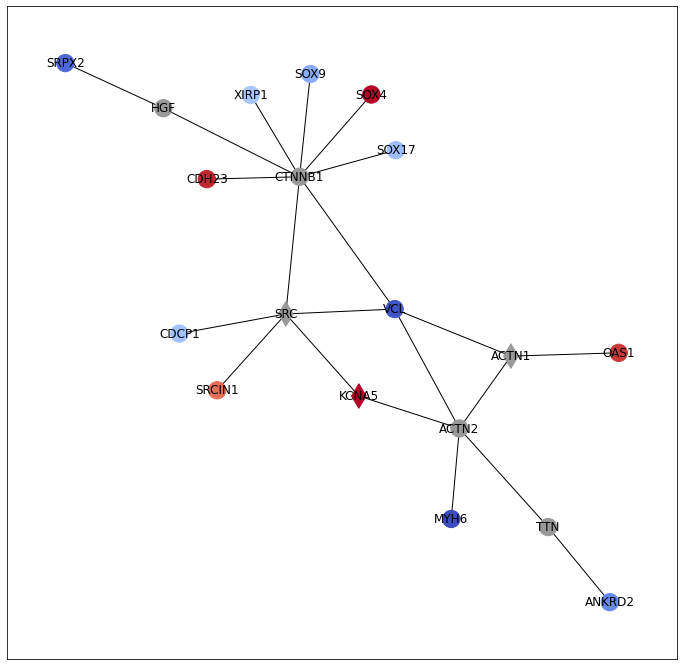

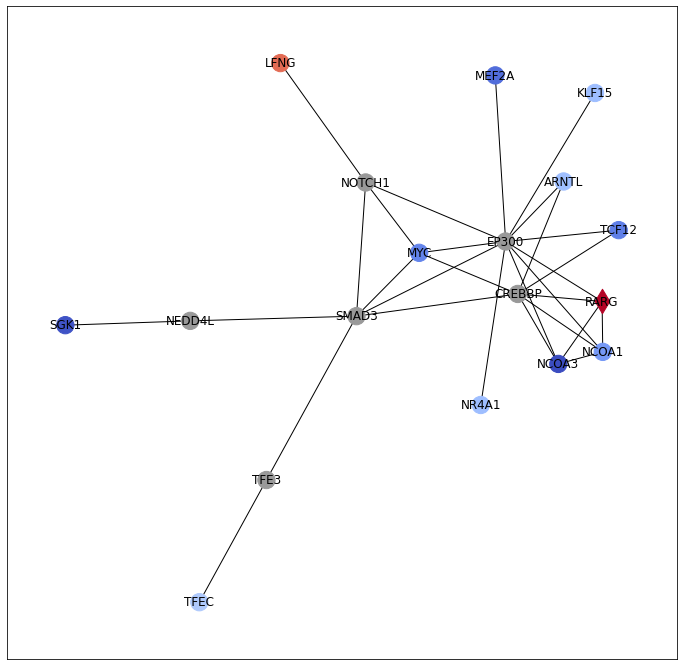

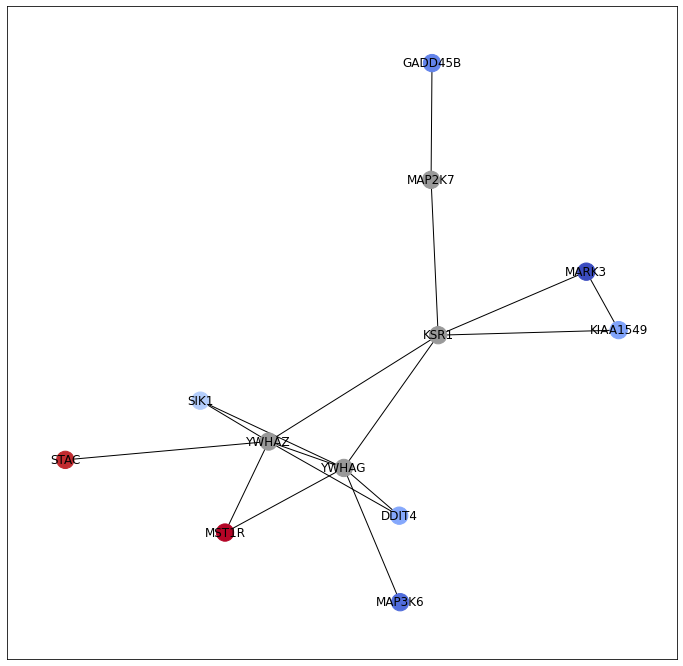

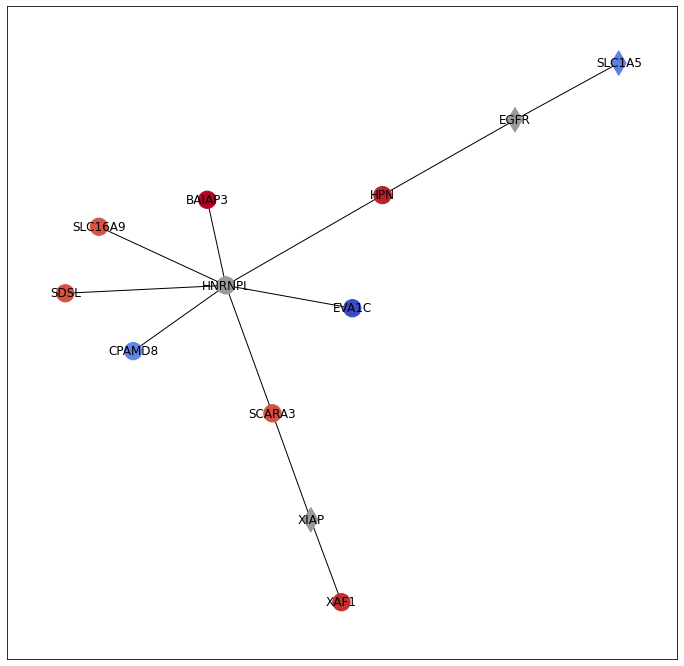

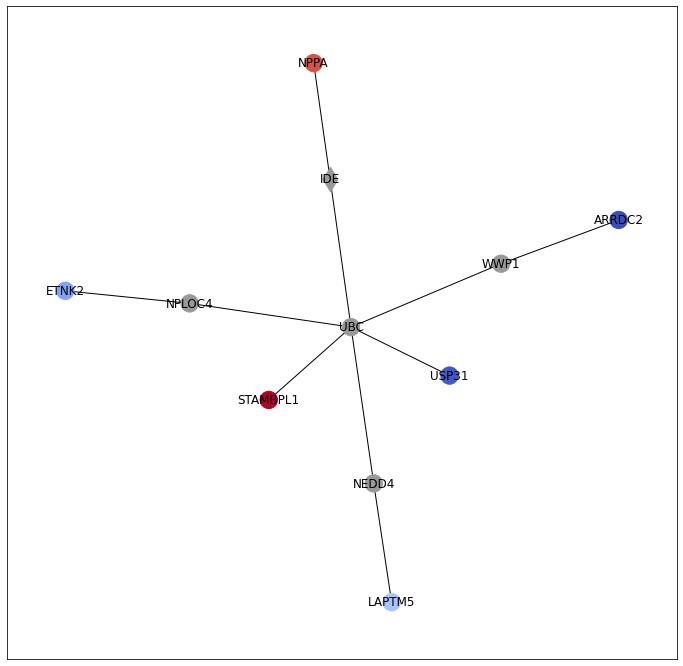

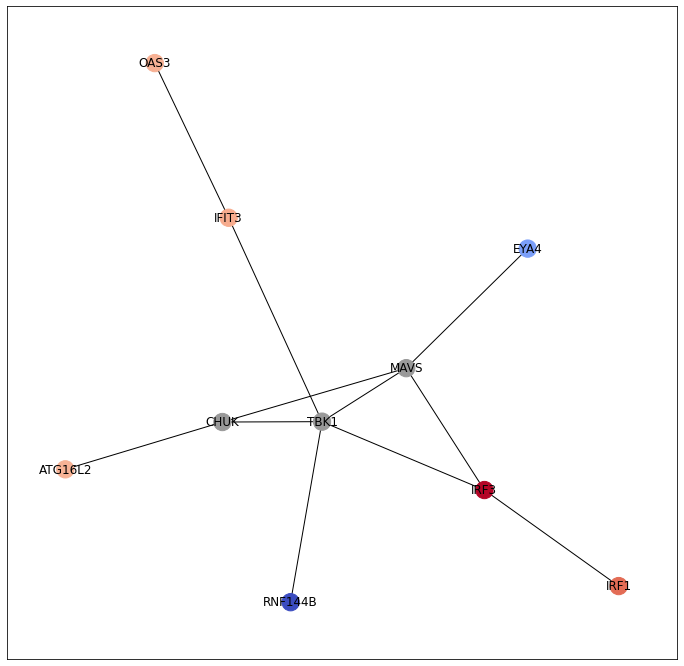

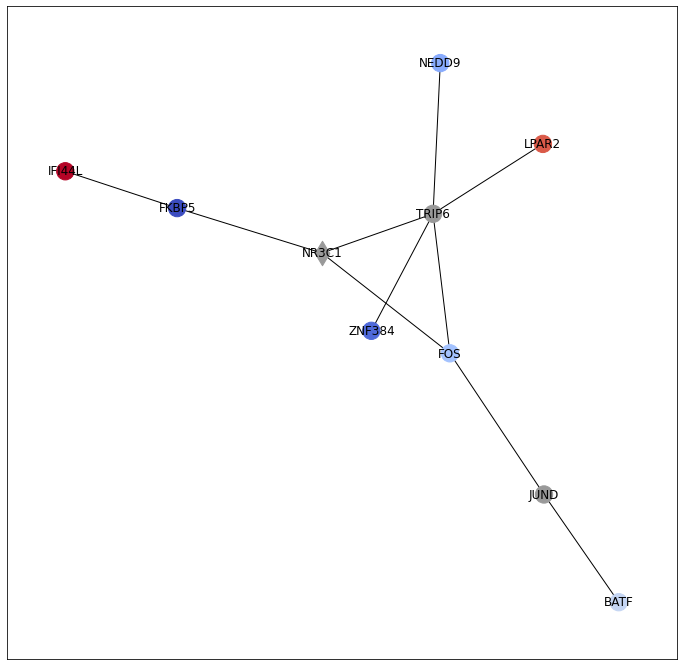

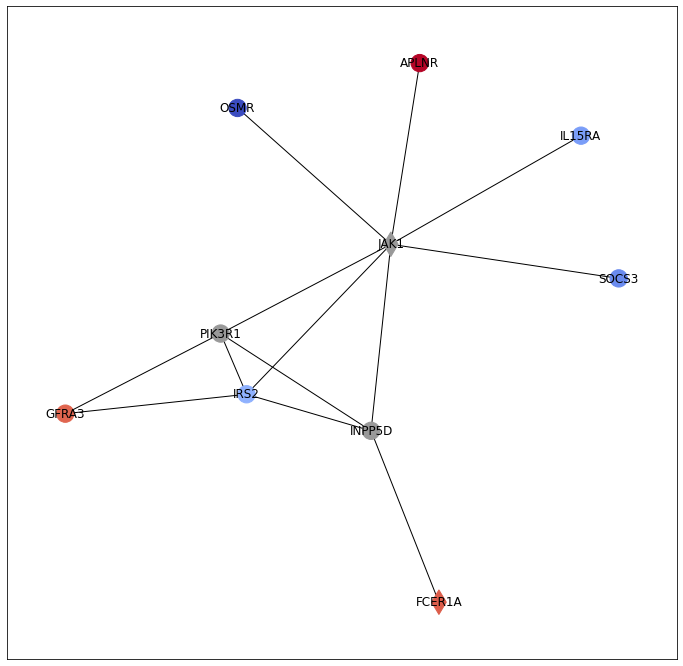

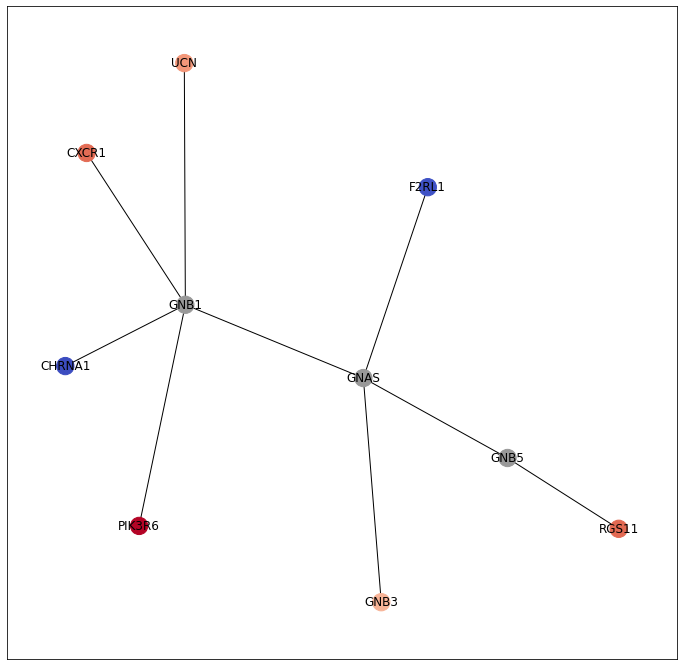

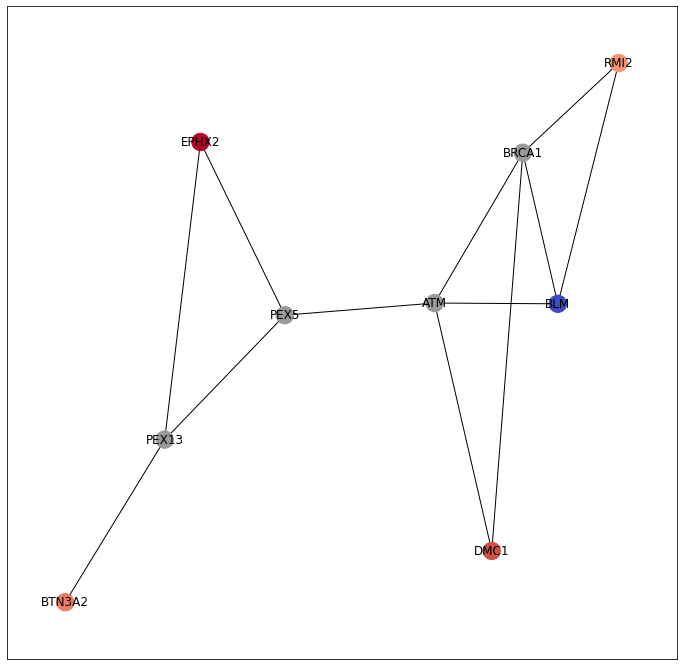

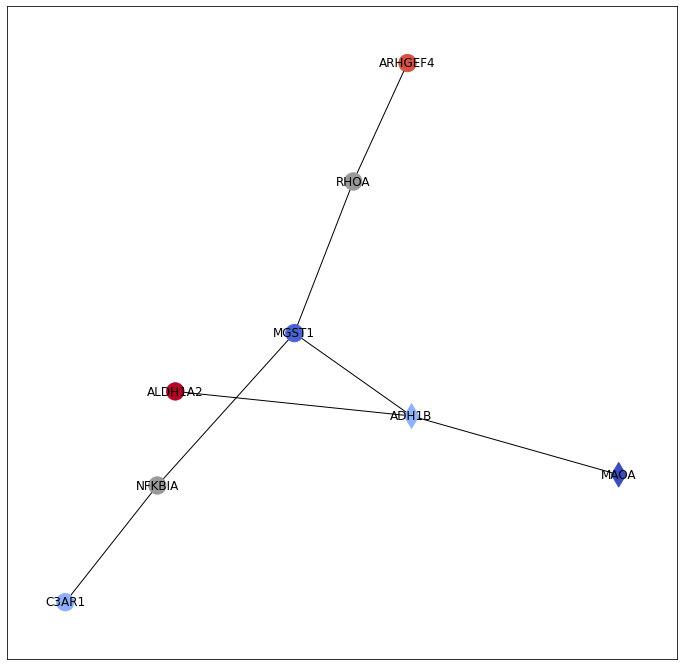

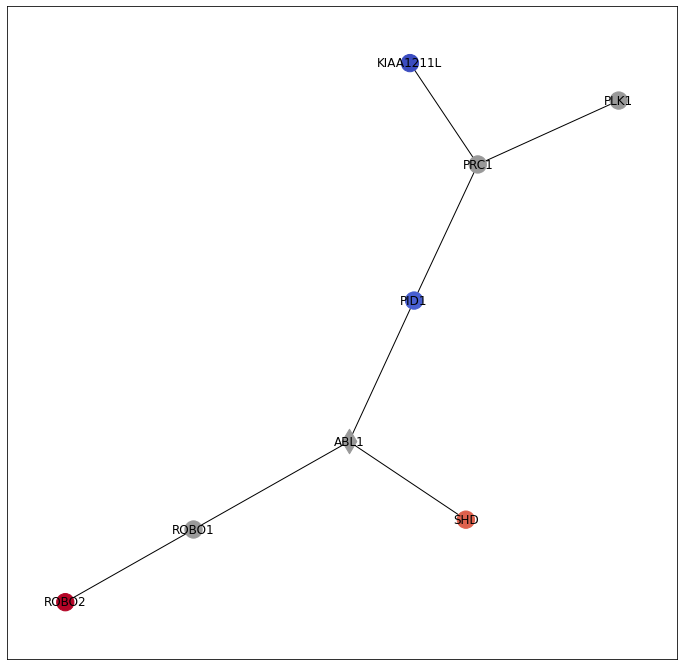

In [27]:
for com in pEF_com_list:
    plot_leiden_com(com, consensusForest_pEF, pEF_seeds, map_path, drug_targets = list(fda_targets.Gene))

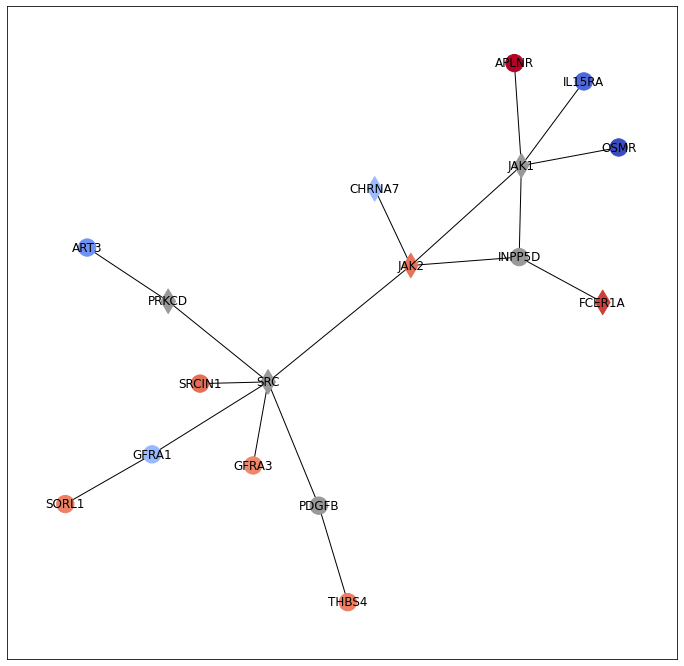

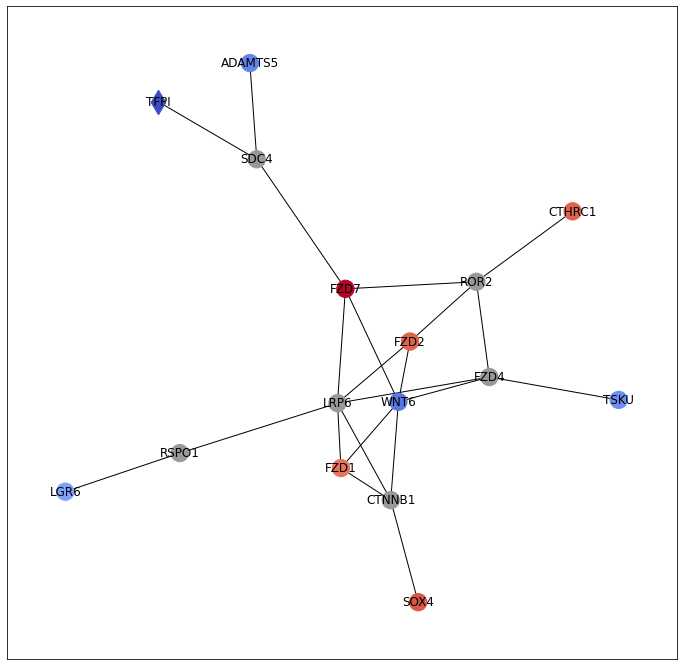

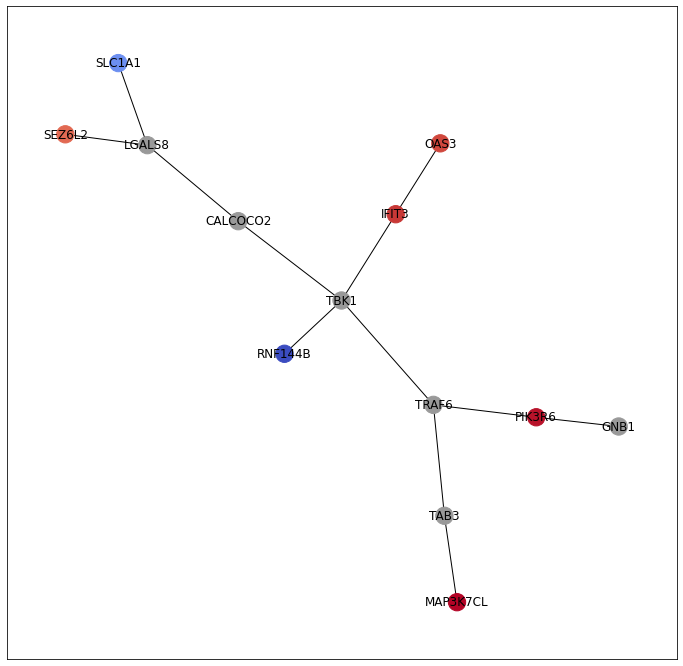

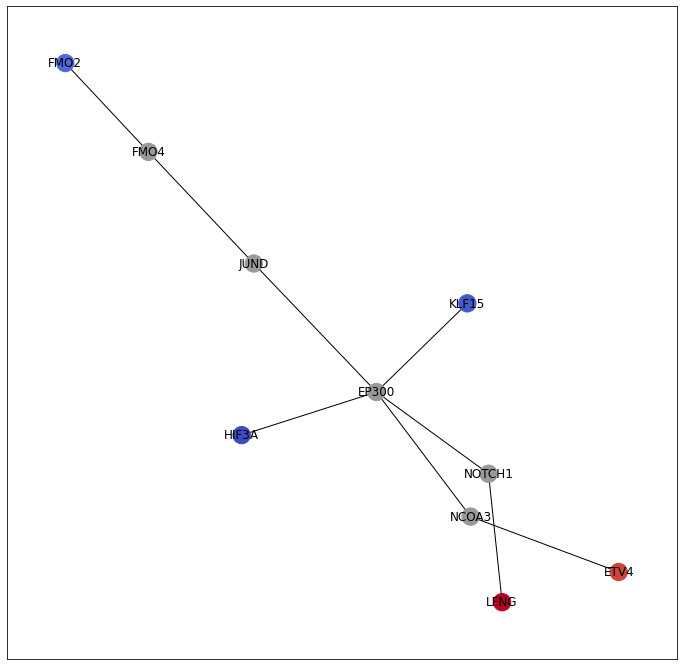

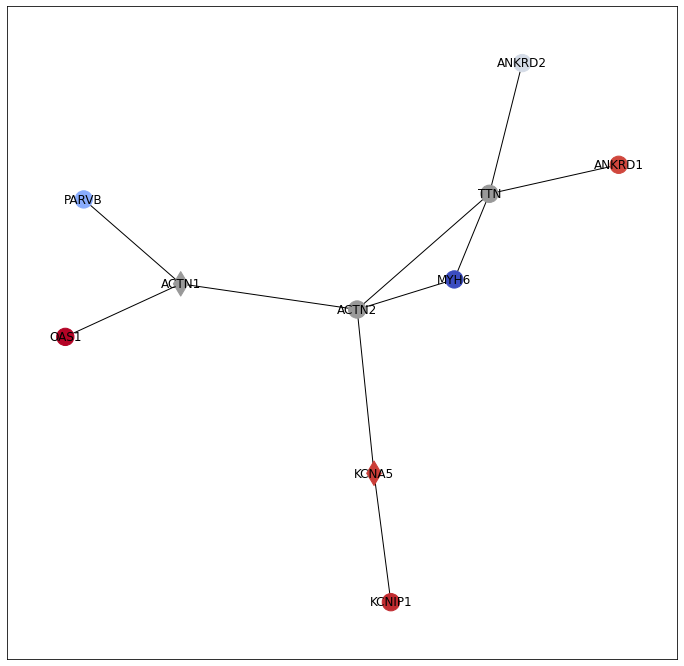

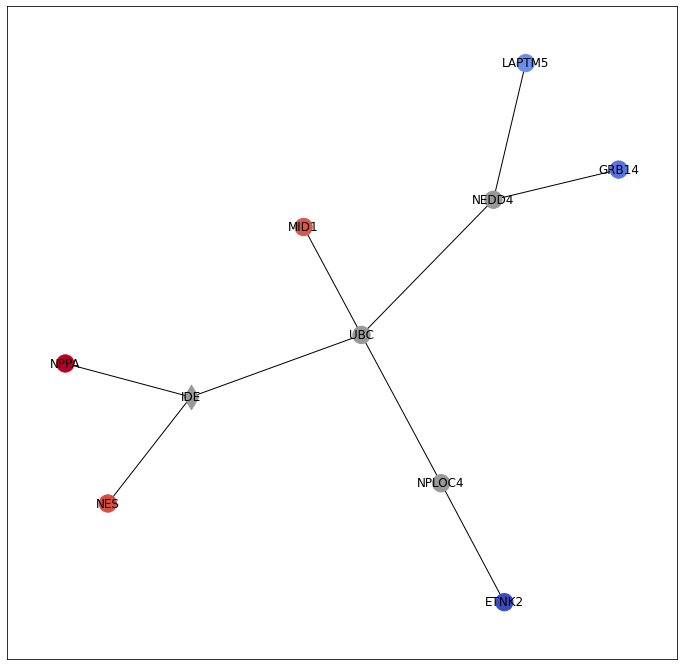

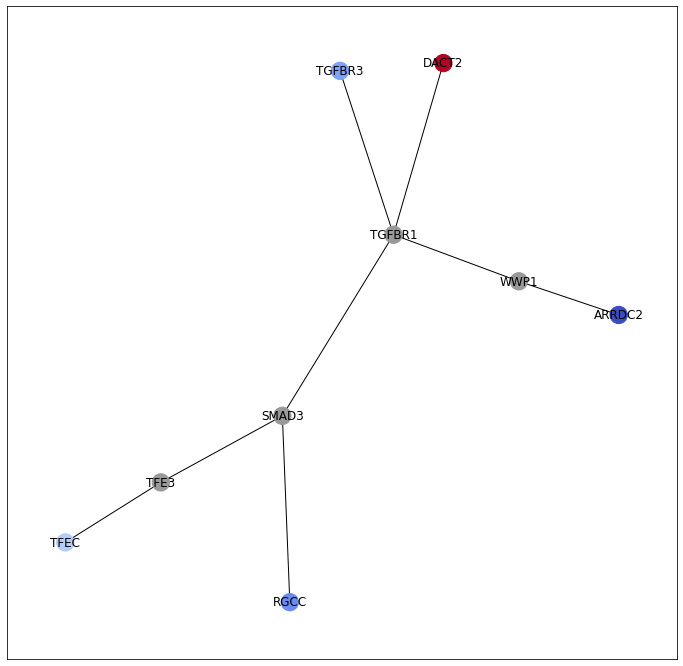

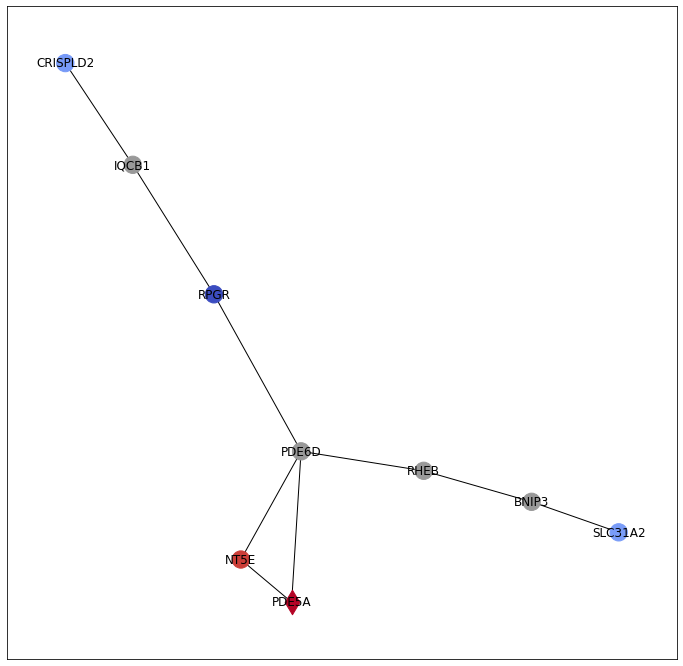

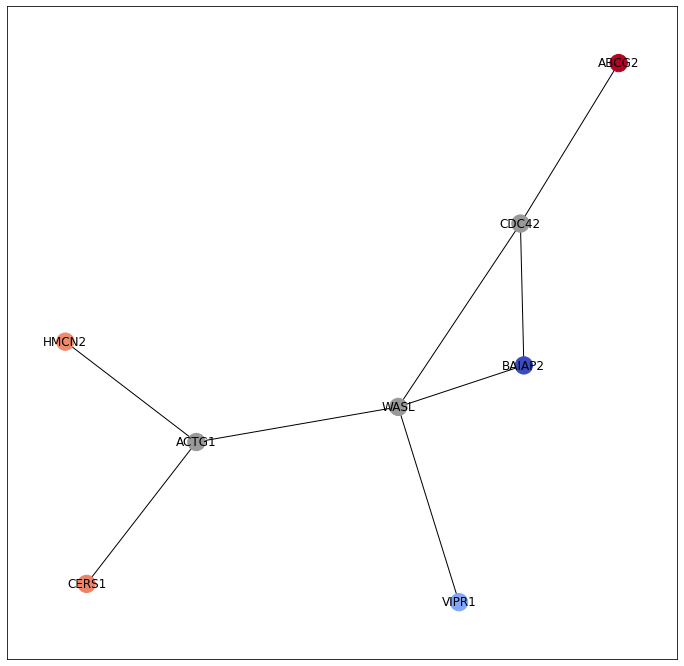

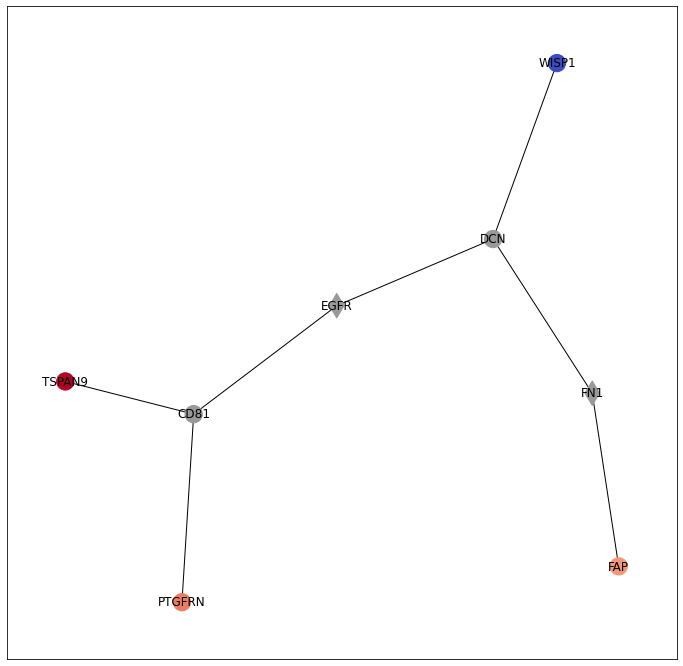

In [28]:
for com in rEF_com_list:
    plot_leiden_com(com, consensusForest_rEF, rEF_seeds, map_path, drug_targets = list(fda_targets.Gene))